In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from sklearn import svm, grid_search
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from tqdm import tqdm
from moviepy.editor import VideoFileClip
from Heatmap import Heatmap
import time
from sklearn.externals import joblib

D:\apps\miniconda\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\apps\miniconda\envs\carnd-term1\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
################################################################################
#loadImagesFromDirectory
# This utility method helps in loading all images in a given directort
# ....input: directory path
# ....output: list of images in RGB format
################################################################################
def loadImagesFromDirectory(directory, extn='png'):
    images = []
    images_path = glob.glob('{}/**/*.{}'.format(directory, extn), recursive=True)
    for image_path in images_path:
        images.append(mpimg.imread(image_path))
    return images

In [3]:
################################################################################
# Load Vehicle and non Vehicle training data
################################################################################
vehicles = loadImagesFromDirectory('./vehicles')
nonVehicles = loadImagesFromDirectory('./non-vehicles')
print('Vehicles {} NonVehicles {}'.format(len(vehicles), len(nonVehicles)))

Vehicles 8792 NonVehicles 8968


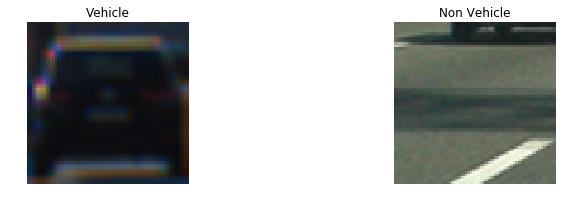

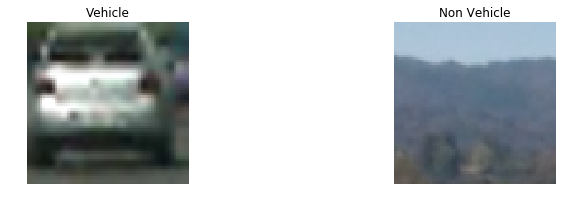

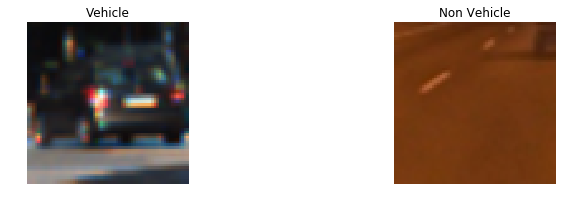

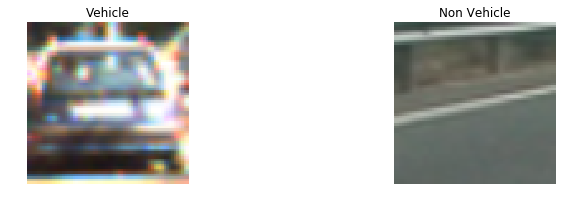

In [4]:
################################################################################
# Visualize training data
################################################################################
indices = np.random.randint(0, len(vehicles), 4)
for i in indices:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(121)
    plt.imshow(vehicles[i])
    plt.title('Vehicle')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(nonVehicles[i])
    plt.title('Non Vehicle')
    plt.axis('off')
    plt.tight_layout()

In [5]:
################################################################################
# convert_color
# Converts color of a given image
################################################################################
def convert_color(image, cspace='YCrCb'):
    if cspace == 'HSV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif cspace == 'LUV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif cspace == 'HLS':
        return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif cspace == 'YUV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif cspace == 'YCrCb':
        return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)


#################################################################################
# get_hog_features
# Extracts Hog features of an image
# Returns Features and optionally Hog Image
################################################################################
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

#################################################################################
# bin_spatial
# returns numpy array of all 3 challens of an image
#################################################################################
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

#################################################################################
# color_hist
# returns ndarray of histograms of all 3 color channels of an image
#################################################################################
def color_hist(img, nbins=32, bins_range=(0, 1), rc=False):
    hist_1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    hist_2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    hist_3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    if rc:
        hist_features = np.array(([hist_1[0], hist_2[0], hist_3[0]]))
        bin_edges = hist_1[1]
        bin_center = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
        return bin_center, hist_features
    else:
        return np.concatenate(([hist_1[0], hist_2[0], hist_3[0]]))

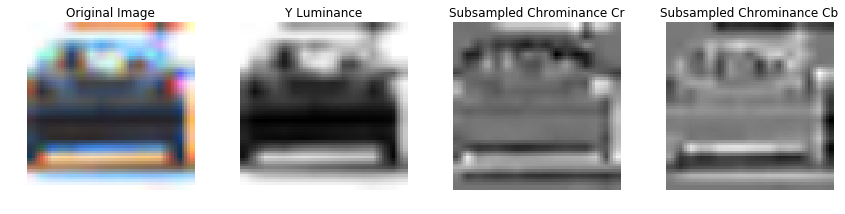

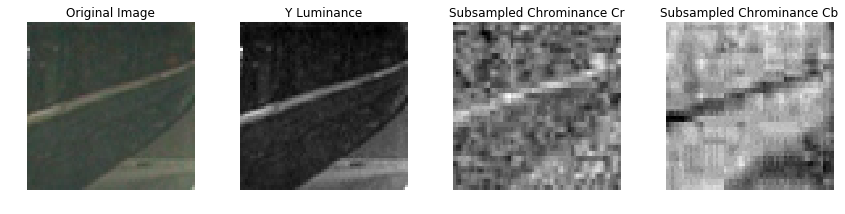

In [6]:
#################################################################################
# Disply train images in defined Color Channel
#################################################################################
ch_images = []
ch_images.append(vehicles[np.random.randint(0, len(vehicles))])
ch_images.append(nonVehicles[np.random.randint(0, len(vehicles))])

for image in ch_images:
    color_img = convert_color(image, cspace='YCrCb')   
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Original Image')
    plt.subplot(142)
    plt.imshow(color_img[:,:,0], cmap='gray')
    plt.axis('off')
    plt.title('Y Luminance')
    plt.subplot(143)
    plt.imshow(color_img[:,:,1], cmap='gray')
    plt.axis('off')
    plt.title('Subsampled Chrominance Cr')
    plt.subplot(144)
    plt.imshow(color_img[:,:,2], cmap='gray')
    plt.axis('off')
    plt.title('Subsampled Chrominance Cb')
    fig.tight_layout()
plt.show()


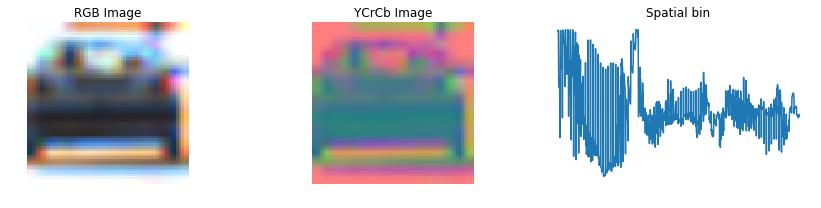

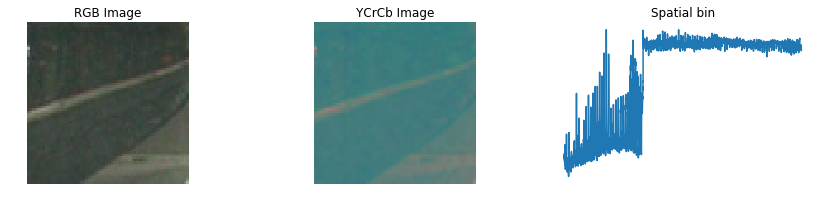

In [7]:
#################################################################################
# Disply Spatial binning of train images
#################################################################################
for image in ch_images:
    c_image = convert_color(image, cspace='YCrCb')
    sb = bin_spatial(c_image)   
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.imshow(image)
    plt.axis('off')
    plt.title('RGB Image')
    plt.subplot(132)
    plt.imshow(c_image)
    plt.axis('off')
    plt.title('YCrCb Image')
    plt.subplot(133)
    plt.plot(sb)
    plt.axis('off')
    plt.title('Spatial bin')
    fig.tight_layout()


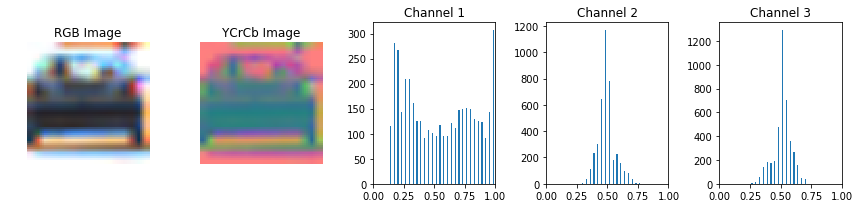

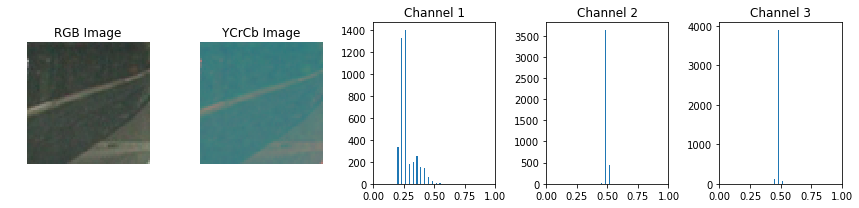

In [8]:
#################################################################################
# Disply color histogram of train images
#################################################################################
for image in ch_images:
    c_image = convert_color(image, cspace='YCrCb')
    center, hist = color_hist(c_image, 32, rc=True)   
    fig = plt.figure(figsize=(12,3))
    plt.subplot(151)
    plt.imshow(image)
    plt.axis('off')
    plt.title('RGB Image')
    plt.subplot(152)
    plt.imshow(c_image)
    plt.axis('off')
    plt.title('YCrCb Image')
    plt.subplot(153)
    plt.xlim(0, 1)
    plt.title('Channel 1')
    plt.bar(center, hist[0], width = 0.01)
    plt.subplot(154)
    plt.bar(center, hist[1], width = 0.01)
    plt.xlim(0, 1)
    plt.title('Channel 2')
    plt.subplot(155)
    plt.bar(center, hist[2], width = 0.01)
    plt.xlim(0, 1)
    plt.title('Channel 3')
    fig.tight_layout()
plt.show()

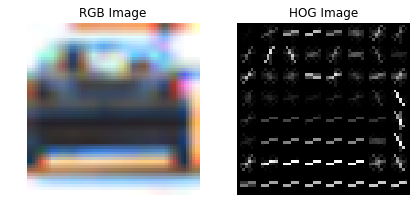

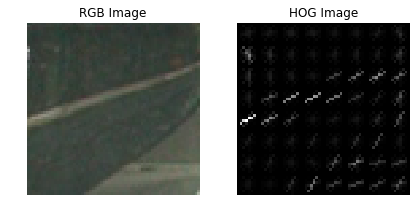

In [9]:
#################################################################################
# Disply HOG histogram of test images
#################################################################################
for image in ch_images:
    c_image = convert_color(image, cspace='YCrCb')
    features, hog_image = get_hog_features(c_image[:,:,0], orient=9, pix_per_cell=8, cell_per_block=8, vis=True)
    fig = plt.figure(figsize=(6,3))
    plt.subplot(121)
    plt.title('RGB Image')
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Image')
    plt.axis('off')
    fig.tight_layout()
plt.show()

In [10]:
#################################################################################
# Extract and combine features
################################################################################## 
def extract_features(images, cspace='YCrCb', orient=11, 
                        pix_per_cell=8, cell_per_block=2, vis=False):
    features = []
    for image in tqdm(images):
        feature_image = convert_color(image, cspace)
        c_hist = color_hist(feature_image)
        s_features = bin_spatial(feature_image)
        hog_features = []
        hog_channel_1 = get_hog_features(feature_image[:,:,0], orient, pix_per_cell, cell_per_block, vis)
        hog_features.append(hog_channel_1)
        hog_features = np.ravel(hog_features)
        feature_vect = np.concatenate((c_hist, s_features, hog_features))
        features.append(feature_vect)
    return features

In [11]:
################################################################################
#   Hyper parameters
################################################################################
COLORSPACE = 'YCrCb'
ORIENT = 9
PIX_PER_CELL = 8
CELL_PER_BLOCK = 2
XSTART = 400
THRESHOLD = 1.0
FRAME_SKIP_RATE = 0
WINDOWS = 64
CELLS_PER_STEP = 2
    
#Make sure slide matrix Y start and End are 
#in ratio of 64 because our window is 64X64
SLIDE_MATRIX = [([400, 464], 1.0), 
                ([416, 480], 1.0),
                ([400, 496], 1.5),
                ([420, 516], 1.5),
                ([400, 528], 2.0),
                ([450, 578], 2.0),
                ([400, 624], 3.5),
                ([464, 660], 3.5)]

In [12]:
#################################################################################
# Extract combined features for Vehicles and non vehicles
##################################################################################
vehicle_features = extract_features(vehicles, cspace=COLORSPACE, orient=ORIENT, 
                        pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK)

nonVehicle_features = extract_features(nonVehicles, cspace=COLORSPACE, orient=ORIENT, 
                        pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK)

features = np.vstack((vehicle_features, nonVehicle_features)).astype(np.float64)  
labels = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(nonVehicle_features))))

print('Total features {}'.format(len(features[0])))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=rand_state)

#################################################################################
# Normalize train and test data and then training model
##################################################################################
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
X_train_norm = X_scaler.transform(X_train)
X_test_norm = X_scaler.transform(X_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8968/8968 [00:42<00:00, 213.41it/s]


Total features 4932


In [13]:
t=time.time()
model_rbf = SVC(C=10, tol=0.05, kernel='rbf')
model_rbf.fit(X_train_norm, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Train Accuracy of SVC = ', round(model_rbf.score(X_train_norm, y_train), 4))
print('Test Accuracy of SVC = ', round(model_rbf.score(X_test_norm, y_test), 4))

joblib.dump(model_rbf, 'model_rbf.pkl')
joblib.dump(X_scaler, 'scaler.pkl')

175.94 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9941


['scaler.pkl']

In [14]:
#################################################################################
#   Load Saved Trained model 
#   ** used in case model needs to be loaded for later use
#################################################################################
model_rbf = joblib.load('model_rbf.pkl')
X_scaler = joblib.load('scaler.pkl')

In [15]:
#################################################################################
#  find_cars
#  Method responsible to extract features for an image and then apply normalization.
# Once data is normalized, trained model is ran on it to detect presence of a vehicle
# This returns list of bounded box co-ordinates of the detected vehicles.
#
#  **This method is taken from Udacity Classroom course**
#################################################################################
def find_cars(image, ystart, ystop, xstart, scale, cspace , 
              model, X_scaler, orient, pix_per_cell, 
              cell_per_block, show_all_rectangles=None):
    rectangles = []
    img = np.copy(image)
    img = img.astype(np.float32)/255
    search_region = img[ystart:ystop,xstart:,:]
    
    #convert image to given colorspace
    processed_image = convert_color(search_region, COLORSPACE)
    if scale != 1:
        imshape = processed_image.shape
        processed_image = cv2.resize(processed_image, 
                                     (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    nxblocks = (processed_image[:,:,0].shape[1] // PIX_PER_CELL)+1
    nyblocks = (processed_image[:,:,0].shape[0] // PIX_PER_CELL)+1 
    
    nblocks_per_window = (WINDOWS // PIX_PER_CELL)-1 
    
    nxsteps = (nxblocks - nblocks_per_window) // CELLS_PER_STEP
    nysteps = (nyblocks - nblocks_per_window) // CELLS_PER_STEP
    
    # Compute HOG features for only 1 channel [0] of image. 
    hog1 = get_hog_features(processed_image[:,:,0],
                            ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, feature_vec=False)   
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*CELLS_PER_STEP
            xpos = xb*CELLS_PER_STEP
            hog_feat = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat))
            xleft = xpos*PIX_PER_CELL
            ytop = ypos*PIX_PER_CELL
            
            # Extract the image patch and Get color features
            subimg = cv2.resize(processed_image[ytop:ytop+WINDOWS, xleft:xleft+WINDOWS], (64,64))
            hist_features = color_hist(subimg)
            s_features = bin_spatial(subimg)

            # Scale features and make a prediction
            revised_features = np.hstack((hist_features, s_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(revised_features)
            test_prediction = model.predict(test_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xstart+ xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(WINDOWS*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),
                                   (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [16]:
#################################################################################
# draw_boxes
# Draws rectangle boxes on image given by bbox parameter
#
# **This method is taken from Udacity Classroom course**
#################################################################################
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=4):
    imcopy = np.copy(img)
    random_color = False
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), 
                     np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

#################################################################################
# add_heat
# Adds heatmap for multiple heatmap images
#
# **This method is taken from Udacity Classroom course**
#################################################################################
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

#################################################################################
# apply_threshold
# Applies threshold of {threshold} value on heatmap images
##################################################################################
def apply_threshold(heatmap, threshold):
    if len(heatmap) > 0 :
        heatmap[heatmap <= threshold] = 0
    return heatmap

#################################################################################
# draw_bounded_bboxes
# Draws bounded boxes around labels on a given images
# It also return co-ordinates of bounded boxes.
#################################################################################
def draw_bounded_bboxes(image, labels):
    bounded_boxes = []
    for prediction in range(1, labels[1]+1):
        nonzero = (labels[0] == prediction).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bounded_boxes.append(bbox)
        cv2.rectangle(image, bbox[0], bbox[1], (0,0,255), 4)
    return image, bounded_boxes

#################################################################################
# hot_to_rgb
# Utility method to convert HOT encoded images to RGB format
#################################################################################
def hot_to_rgb(heatmap):
    min_value, max_value = np.amin(heatmap), np.amax(heatmap)
    normalized_heatmap = (heatmap - min_value) / (max_value - min_value)
    colormap = plt.cm.get_cmap('hot') 
    rgba = colormap(normalized_heatmap) 
    r, g, b = rgba[:, :, 0], rgba[:, :, 1], rgba[:, :, 2]
    rgb_img = np.dstack((r, g, b))
    return rgb_img*255

#################################################################################
# merge_images
# Utility method to stich multiple child images in one parent image
#################################################################################
def merge_images(parent, childImages):
    x_start = 20
    y_start = 20
    for img in childImages:
        x_end = x_start + 400
        y_end = y_start + 200
        insert = cv2.resize(img, (400, 200), interpolation=cv2.INTER_CUBIC)
        parent[y_start:y_end, x_start:x_end] = insert
        x_start = x_end+5
    return parent

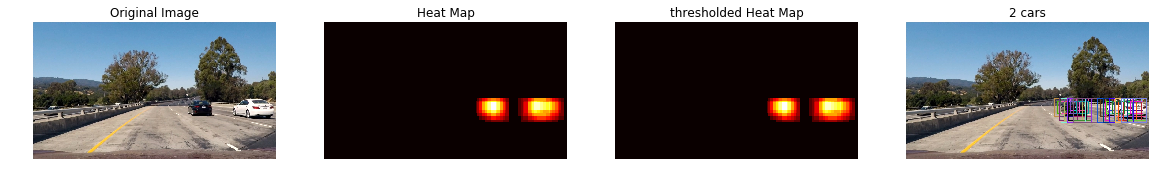

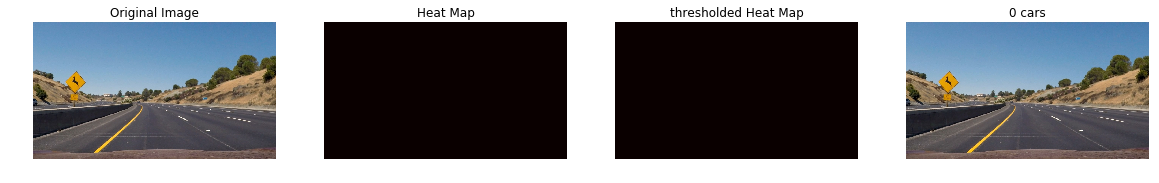

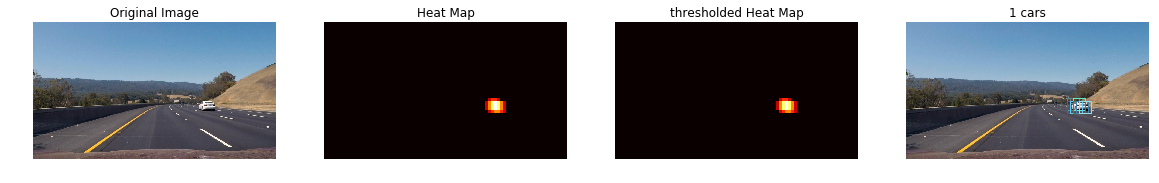

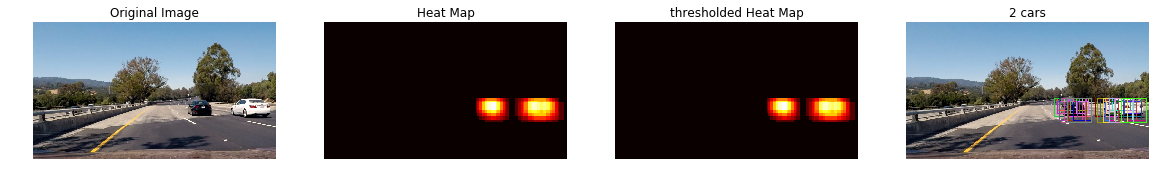

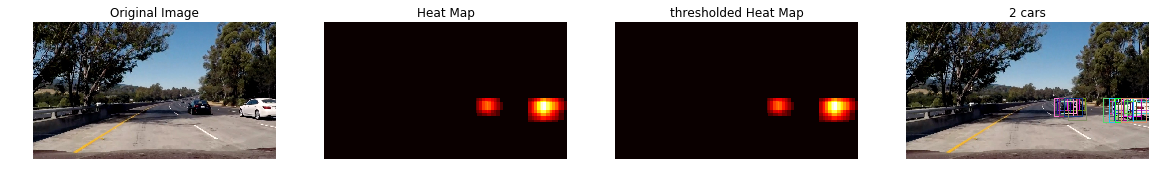

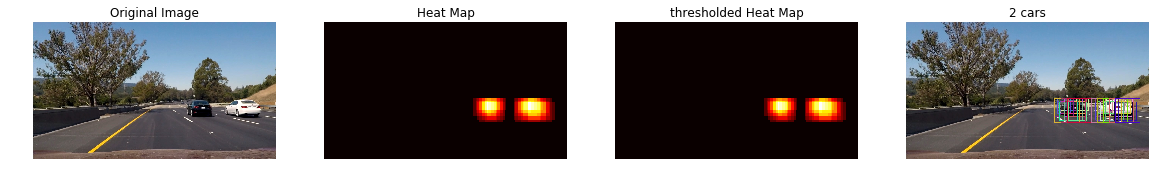

In [17]:
#################################################################################
# Display multiple stages of image processing to detect Vehicles
#################################################################################
test_images = loadImagesFromDirectory('./test_images', 'jpg')

for test_image in test_images:
    bounded_boxes = []
    for slide_pos in SLIDE_MATRIX:
        y_pos = slide_pos[0]
        bounded_boxes.append(find_cars(test_image, y_pos[0], y_pos[1], XSTART, slide_pos[1], 
                                       COLORSPACE, model_rbf, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None))

    output_img = np.copy(test_image)
    flattened_box_list = []
    for bbox_list in bounded_boxes:
        for bboxes in bbox_list:
           flattened_box_list.append(bboxes)

    output_img = draw_boxes(output_img, flattened_box_list, color='random', thick=4)
    heatmap_img = np.zeros_like(test_image[:,:,0])
    heatmap_img = add_heat(heatmap_img, flattened_box_list)
    thresh_heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(thresh_heatmap_img)

    fig = plt.figure(figsize=(20,8))
    plt.subplot(141)
    plt.imshow(test_image)
    plt.axis('off')
    plt.title('Original Image')
    
    plt.subplot(142)
    plt.imshow(heatmap_img, cmap='hot')
    plt.axis('off')
    plt.title('Heat Map')
    
    plt.subplot(143)
    plt.imshow(thresh_heatmap_img, cmap='hot')
    plt.axis('off')
    plt.title('thresholded Heat Map')
    
    plt.subplot(144)
    plt.imshow(output_img)
    plt.axis('off')
    plt.title('{} cars'.format(labels[1]))
    plt.show()

In [18]:
from random import random
def pipeline(image):
    global heatmap 
    bounded_boxes = []
    
    for slide_pos in SLIDE_MATRIX:
        y_pos = slide_pos[0]
        bounded_boxes.append(find_cars(image, y_pos[0], y_pos[1], XSTART, slide_pos[1], COLORSPACE, model_rbf,
                                       X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, None))
    flattened_box_list = []
    for bbox_list in bounded_boxes:
        for bboxes in bbox_list:
           flattened_box_list.append(bboxes)

    heatmap_img = np.zeros_like(image[:,:,0])
    heatmap_img = add_heat(heatmap_img, flattened_box_list)
    avg_heat_map = heatmap.pushIn(heatmap_img)

        
    avg_heat_map = apply_threshold(avg_heat_map, THRESHOLD)
    labels = label(avg_heat_map)
    out_image, bounded_boxes = draw_bounded_bboxes(np.copy(image), labels)
    
    if len(avg_heat_map) < 1:
        avg_heat_map = np.zeros_like(image[:,:,0])
    insert_hot_rgb = hot_to_rgb(avg_heat_map)
    insert_full_boxes = np.copy(image)
    insert_full_boxes = draw_boxes(insert_full_boxes, flattened_box_list, color='random', thick=4)
    images_to_insert = [insert_full_boxes, insert_hot_rgb]
    out_image = merge_images(out_image, images_to_insert)
    
    return out_image

In [19]:
#################################################################################
#  This code block creates an instance of HeatMap class to perform averaging
#  and then processes project video to generate video with bounded boxes
#  annotated.
#################################################################################
heatmap = Heatmap(20)
prj_video = 'project_video.mp4'
proj_out_file = 'project_video_out.mp4'
video_clip = VideoFileClip(prj_video)
video_clip_out = video_clip.fl_image(pipeline)
%time video_clip_out.write_videofile(proj_out_file, audio=False)
video_clip.reader.close()

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [2:28:08<00:06,  6.09s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 2h 28min 11s
